In [8]:
import pandas as pd
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import scipy

from astropy.cosmology import Planck15
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table
import astropy 
from ligo.skymap.io import fits
from ligo.skymap.postprocess import find_greedy_credible_levels

import os
from os import listdir
from os.path import isfile, join

import sys
from tqdm import tqdm

H0GLOB=67 #69
Om0GLOB=0.319
Xi0Glob =1.
cosmoglob = Planck15
clight = 2.99792458* 10**5#km/s
cosmoflag = FlatLambdaCDM(H0=H0GLOB, Om0=Om0GLOB)


In [9]:
def get_ename(fname, verbose=True):

        if len(fname.split('/')[-1].split('_')) <= 2:    #Same as before since certain names contain a "_"
            event_name = fname.split('/')[-1].split('_')[0]
        elif len(fname.split('/')[-1].split('_')) > 2:
            event_name = fname.split('/')[-1].split('_')[0]+'_'+fname.split('/')[-1].split('_')[1]
        else:
            raise ValueError('Could not set event name. Got fname= %s'%fname)
        if verbose:
            print('-- %s' %event_name)
        return event_name
    
def find_ra_dec(nside, pix):
        '''
        input:  pixel ra dec in degrees
        output: (ra, dec) of pixel center in degrees, with nside given by that of the skymap 
        '''
        theta, phi =find_theta_phi(nside,pix)
        ra, dec = ra_dec_from_th_phi(theta, phi)
        return ra, dec    
    
def ra_dec_from_th_phi(theta, phi):
        ra = np.rad2deg(phi)
        dec = np.rad2deg(0.5 * np.pi - theta)
        return ra, dec
    
def find_theta_phi(nside, pix):
        '''
        input:  pixel
        output: (theta, phi)of pixel center in rad, with nside given by that of the skymap 
        '''
        return hp.pix2ang(nside, pix, nest=True)
    
def _read_O3( fname, convert_nested=True):
        
        skymap, metadata = fits.read_sky_map(fname, nest=None, distances=True) #Read the skymap
        event_name = get_ename(fname, verbose=True)
        print('Event: %s' %event_name)
        if (convert_nested) & (metadata['nest']): #If one wants RING ordering (the one of O2 data afaik) just has to set "convert_nested" to True
            p_posterior = hp.reorder(skymap[0],n2r=True)
            mu = hp.reorder(skymap[1],n2r=True)
            sigma = hp.reorder(skymap[2],n2r=True)
            posteriorNorm = hp.reorder(skymap[3],n2r=True)
            print('convertito da nested a ring')
        else:
            p_posterior= skymap[0]
            mu= skymap[1]
            sigma = skymap[2]
            posteriorNorm= skymap[3]        
        npix = len(p_posterior)
        nside=hp.npix2nside(npix)
        theta,phi=find_theta_phi(nside,np.argmax(p_posterior))
        #print('Theta={}, Phi={}'.format(theta, phi))
        #ra, dec=find_ra_dec(nside,np.argmax(p_posterior))
        #print('Right Ascension={}, Declination={}'.format(ra, dec))
        #print(metadata)
        #dl=metadata['distmean']
        #std=metadata['diststd']
        #z=cosmoglob.H(0).value*dl/clight
        #sigz=cosmoglob.H(0).value*std/clight
        #print('dL={}Mpc, std={}Mpc'.format(dl,std))
        #print('z={}, delta_z={}'.format(z,sigz))
        #print('\n')
        head = None
def z_from_dL(dL_GW_val):
    '''
    Returns redshift for a given luminosity distance dL_GW_val (in Mpc)
    
    Input:
        - dL_GW_val luminosity dist in Mpc
        - H0
        - Xi0: float. Value of Xi_0
        - n: float. Value of n

    '''   
    from scipy.optimize import fsolve
    #print(cosmo.H0)
    func = lambda z : cosmoflag.luminosity_distance(z).value - dL_GW_val
    z = fsolve(func, 1)
    return z[0]

def mygaussint(prov_mu,prov_sigma,rho=1):
    first=np.exp(-(prov_mu**2)/(2*prov_sigma**2))*prov_mu*rho*prov_sigma/np.sqrt(2*np.pi)
    factor=0.5*rho*(prov_mu**2+prov_sigma**2)
    second=(1+scipy.special.erf(prov_mu/(np.sqrt(2)*prov_sigma)))
    ret=first+factor*second
    return ret

def sphere_uncorr_gauss(x,y,mux,muy,sigx,sigy):
    #correlation is 0 so is a multiplication of two gaussians
    #x is theta, y is phi
    meanvec=hp.ang2vec(mux,muy)
    meanvec=np.asarray(meanvec)
    norm=np.sqrt(np.dot(meanvec,meanvec))
    meanvec=meanvec/norm
    
    var=hp.ang2vec(x,y)
    var=np.asarray(var)
    norm=np.sqrt(np.dot(var,var))
    var=var/norm
    
    diff=meanvec-var
    diff_len=np.sqrt(np.dot(diff,diff))
    #xfactor=((x-mux)/sigx)**2
    #yfactor=((y*(1-np.sin(y))-muy*(1-np.sin(muy)))/sigy)**2
    #yfactor=((y-muy)/sigy)**2
    #norm=2*np.pi*sigx*sigy
    factor=((diff_len)/sigy)**2
    ret=np.exp(-(1/2)*(factor))#/norm
    return ret

def Mises_Fisher(theta,phi,DS_theta,DS_phi,conc):
    meanvec=hp.ang2vec(DS_theta,DS_phi)
    meanvec=np.asarray(meanvec,dtype=np.float128)
    norm=np.sqrt(np.dot(meanvec,meanvec))
    meanvec=meanvec/norm
    
    var=hp.ang2vec(theta,phi)
    var=np.asarray(var,dtype=np.float128)
    norm=np.sqrt(np.dot(var,var))
    var=var/norm
    
    factor=np.dot(conc*var,meanvec)
    factor=np.float128(factor)
    #Normalization is futile, we will devide by the sum
    #fullnorm=conc/(2*np.pi*(np.exp(conc)-np.exp(-conc)))
    ret=np.float128(np.exp(factor))#/fullnorm
    #ret=factor
    return ret

In [18]:
#GWdata path
GW_data_path='/home/rciancarella/DarkSirensStat/data/GW/Hold_O3/'
os.chdir(GW_data_path)
#all_event=os.listdir()


  # Function to exploit, find how to localise an event and produce a proxy one. 
   def _read_O3(self, fname, convert_nested=True):
        
   skymap, metadata = fits.read_sky_map(fname, nest=None, distances=True) #Read the skymap
        self.event_name = get_ename(fname, verbose=self.verbose)
        if self.verbose:
                print('\nEvent: %s' %self.event_name)
                #Raul: prints for control
                print('Delta=%s. If delta=1, normal run '%delta)
        if (convert_nested) & (metadata['nest']): #If one wants RING ordering (the one of O2 data afaik) just has to set "convert_nested" to True
            self.p_posterior = hp.reorder(skymap[0],n2r=True)
            self.mu = hp.reorder(skymap[1],n2r=True)
            self.sigma = hp.reorder(skymap[2],n2r=True)*delta
            self.posteriorNorm = hp.reorder(skymap[3],n2r=True)
        else:
            self.p_posterior= skymap[0]
            self.mu= skymap[1]
            self.sigma = skymap[2]*delta
            self.posteriorNorm= skymap[3]    

In [20]:
#Some files to look at 
filenames=['GW190814_PublicationSamples.fits',
           'GW190924_021846_PublicationSamples.fits',
           'GW190412_PublicationSamples.fits',
           'GW190915_235702_PublicationSamples.fits',
           'GW190708_232457_PublicationSamples.fits',
           'GW190421_213856_PublicationSamples.fits',
           'GW190527_092055_PublicationSamples.fits' 
           ]
########################## THIS GIVE US SOME INFO ######################################
#for name in filenames:
#    _read_O3(name)
########################################################################################
fname ='GW190814_PublicationSamples.fits'
alldl=[]
for fname in filenames:
    print(fname)
    skymap, metadata = fits.read_sky_map(fname, nest=None, distances=True)
    p_posterior= skymap[0]
    mu= skymap[1]
    sigma = skymap[2]
    posteriorNorm= skymap[3]        
    npix = len(p_posterior)
    nside=hp.npix2nside(npix)
    theta,phi=find_theta_phi(nside,np.argmax(p_posterior))
    ra, dec=find_ra_dec(nside,np.argmax(p_posterior))
    print('RA={},dec={},theta={},phi={}'.format(ra,dec,theta,phi))
#10 deg^2 =0.000 304 617 419 786 71 sr
    radius_deg= np.sqrt(30/np.pi)
    sigma_deg=radius_deg/2.8
    circle_deg=6*sigma_deg
    alldl.append(mu[np.argmax(p_posterior)])
    print('Dl={}'.format(mu[np.argmax(p_posterior)]))
    sig_avr=np.average(sigma,weights=p_posterior)
    print('average luminosity distance Sigma={} Mpc'.format(sig_avr))
alldl=np.asarray(alldl)
print(np.mean(alldl))

GW190814_PublicationSamples.fits
RA=12.7001953125,dec=-24.87076339473571,theta=2.004873035517517,phi=0.22166022384947515
Dl=235.45665178530027
average luminosity distance Sigma=26.530261090991182 Mpc
GW190924_021846_PublicationSamples.fits
RA=127.265625,dec=16.25709623792208,theta=1.2870564706295728,phi=2.2212041808584084
Dl=499.3721200365884
average luminosity distance Sigma=134.49092733306685 Mpc
GW190412_PublicationSamples.fits
RA=218.4521484375,dec=36.42357364233115,theta=0.9350850413935945,phi=3.812709248289761
Dl=714.0899052030237
average luminosity distance Sigma=92.22291002240516 Mpc
GW190915_235702_PublicationSamples.fits
RA=195.46875,dec=37.26258031838149,theta=0.9204416124503026,phi=3.411573272257666
Dl=1591.1906291650755
average luminosity distance Sigma=422.8751010649481 Mpc
GW190708_232457_PublicationSamples.fits
RA=199.77272727272725,dec=65.69633519657744,theta=0.4241789711207841,phi=3.4866918465977625
Dl=867.5678481523114
average luminosity distance Sigma=195.8886531655

In [ ]:
my_theta,my_phi=hp.pix2ang(nside, np.argmax(p_posterior), nest=True)
vec = hp.ang2vec(my_theta, my_phi)
my_maxpix=hp.ang2pix(nside, my_theta, my_phi,nest=True)
maxpix=np.argmax(p_posterior)
print(maxpix,my_maxpix)

In [ ]:
print(vec)

In [ ]:
hp.mollview(p_posterior, title=fname,nest=True)

In [ ]:
credible_levels = find_greedy_credible_levels(p_posterior)
Ligo_Area_99_deg=np.sum(credible_levels <= 0.99) * hp.nside2pixarea(nside, degrees=True)
Ligo_Area_90_deg=np.sum(credible_levels <= 0.9) * hp.nside2pixarea(nside, degrees=True)
print('Ligo area_deg 99% is {}\nLigo area_deg 90% is {} '.format(Ligo_Area_99_deg,Ligo_Area_90_deg))

In [ ]:
_read_O3(fname)

In [ ]:
vec = hp.ang2vec(my_theta, my_phi)
ipix_disc = hp.query_disc(nside=nside, vec=vec, radius=np.radians(circle_deg), nest=True)
ipix_90 = hp.query_disc(nside=nside, vec=vec, radius=np.radians(radius_deg), nest=True)
m =np.zeros(len(p_posterior))
m[ipix_disc] = 1/len(ipix_disc)
hp.mollview(m, title="Gaussian Mask",nest=True)

In [ ]:
Mock_Area_deg=len(ipix_disc) * hp.nside2pixarea(nside, degrees=True)
Mock_Area_90_deg=len(ipix_90) *hp.nside2pixarea(nside, degrees=True)
print('99.9999% area is {} squared deg\n90% area is {} squared deg'.format(Mock_Area_deg,Mock_Area_90_deg))

In [ ]:
'''
https://emfollow.docs.ligo.org/userguide/tutorial/skymaps.html(for ref on skymap)

Now we need to rescale the probability. We set the prob=0 ouside the circle
We assume that the renormalization is constant.
We crate a mask with our circle. Outside the mask p_posterior=0, the renormalization
constan alpha, is therefore 1/sum(p_posterior()). This ensure unitarity. 

If this works, than we will use a 2D Gaussian distribution for the probability

'''


In [ ]:
#saved_prob=np.zeros(len(p_posterior))
#saved_prob[ipix_disc]=p_posterior[ipix_disc]
#prob_to_write=np.zeros(len(p_posterior))
#alpha=1/np.sum(saved_prob)
#prob_to_write[ipix_disc]=alpha*saved_prob[ipix_disc]

In [ ]:
#print(np.sum(prob_to_write))

In [ ]:
#hp.mollview(prob_to_write, title="Mollview image NESTED",nest=True)

In [ ]:
#my_sky_tosave=(prob_to_write,skymap[1],sigma,posteriorNorm)
#my_sky_tosave=np.array([prob_to_write,mu,sigma,posteriorNorm])
#dat=Table([prob_to_write,mu,sigma,posteriorNorm],
#          names=('PROB','DISTMU','DISTSIGMA','DISTNORM'))
#dat.write('Amap.fits',format='fits',overwrite=True)
#fits.write_sky_map('Amap.fits',dat, nest=True)

In [ ]:
#check result

In [ ]:
#my_data,my_meta=fits.read_sky_map("Amap.fits",nest=None, distances=True)
#print(my_meta)

In [ ]:
#hp.mollview(my_data[0], title="Mollview image NESTED",nest=True)

In [ ]:
#print(my_meta)

In [ ]:
#_read_O3('Amap.fits')

In [ ]:
temp_theta,temp_phi=find_theta_phi(nside,np.argmax(gaussmap))
temp_ra, temp_dec=find_ra_dec(nside,np.argmax(gaussmap))
print('GW221005 location: theta={}, phi={}, RA={}, DEC={}'.format(temp_theta,temp_phi,temp_ra,temp_dec))

In [ ]:
fname ='GW221900_PublicationSamples.fits'
my_data,my_meta=fits.read_sky_map(fname,nest=None, distances=True)

In [ ]:
my_prob=my_data[0]
my_mu=my_data[1]
my_sigma=my_data[2]
npix = len(my_prob)
nside=hp.npix2nside(npix)
#my_mu[np.isinf(my_mu)]=0
hp.mollview(my_prob, title=fname,nest=True)

In [ ]:
my_theta,my_phi=find_theta_phi(nside,np.argmax(my_prob))
my_ra, my_dec=find_ra_dec(nside,np.argmax(my_prob))
print('GW location: theta={}, phi={}, RA={}, DEC={}'.format(my_theta,my_phi,my_ra,my_dec))
mu_avr=np.average(my_mu,weights=my_prob)
print('average luminosity distance={} Mpc'.format(mu_avr))
sig_avr=np.average(my_sigma,weights=my_prob)
print('average luminosity distance Sigma={} Mpc'.format(sig_avr))
z_gw=z_from_dL(mu_avr)
print('redshift={}, in flagship cosmology'.format(z_gw))
comov=mu_avr/(1+z_gw)
print('comoving distance={}'.format(comov))

In [ ]:
np.argmax(my_prob)
maxtheta,maxphi=hp.pix2ang(nside, 841536)
vicini=hp.get_all_neighbours(nside,maxtheta,maxphi)
print(maxtheta,maxphi)
print(vicini)

In [ ]:
for i in vicini:
    maxtheta,maxphi=hp.pix2ang(nside, i, nest=True)
    print(hp.get_all_neighbours(nside,maxtheta,maxphi,nest=True))

In [ ]:
if(np.isnan(my_prob).any()):
    print("The Array contain NaN values")
else:
    print("The Array does not contain NaN values")
if(np.isnan(my_mu).any()):
    print("The Array contain NaN values")
else:
    print("The Array does not contain NaN values")
    
if(np.isinf(my_prob).any()):
    print("The Array contain inf values")
else:
    print("The Array does not contain inf values")
if(np.isinf(my_mu).any()):
    print("The Array contain inf values")
else:
    print("The Array does not contain inf values")

In [ ]:
credible_levels = find_greedy_credible_levels(gaussmap)
Ligo_Area_99_deg=np.sum(credible_levels <= 0.99) * hp.nside2pixarea(nside, degrees=True)
Ligo_Area_90_deg=np.sum(credible_levels <= 0.9) * hp.nside2pixarea(nside, degrees=True)
print('Ligo area_deg 99% is {}\nLigo area_deg 90% is {} '.format(Ligo_Area_99_deg,Ligo_Area_90_deg))


In [ ]:
my_theta,my_phi=find_theta_phi(nside,np.argmax(my_prob))
my_ra, my_dec=find_ra_dec(nside,np.argmax(my_prob))
print('GW location: theta={}, phi={}, RA={}, DEC={}'.format(my_theta,my_phi,my_ra,my_dec))
mu_avr=np.average(my_mu,weights=my_prob)
print('average luminosity distance={} Mpc'.format(mu_avr))
sig_avr=np.average(my_sigma,weights=my_prob)
print('average luminosity distance Sigma={} Mpc'.format(sig_avr))
z_gw=z_from_dL(mu_avr)
print('redshift={}, in flagship cosmology'.format(z_gw))
comov=mu_avr/(1+z_gw)
print('comoving distance={}'.format(comov))

In [ ]:
np.sum(my_mu[0:3]*my_prob[0:3])

In [ ]:
len(my_mu)==len(my_prob)

# Automatic Map Creator 

z_min=0.7887375950813293, z_max=2.0129446983337402
ra_min=1.558116673550103e-05, ra_max=89.99999237060547
dec_min=2.9646462280652486e-06, dec_max=89.98294830322266
phi_min=2.7194266749575036e-07, phi_max=1.5707961320877075
theta_min=0.0002976218846182377, theta_max=1.570796275052059

In [13]:
GW_data_path='/home/rciancarella/DarkSirensStat/data/GW/O3/'
os.chdir(GW_data_path)

In [21]:
fisher=0
if fisher==1:
    conc=4740
    sigma_phi=np.sqrt(1/conc)
    sigma_theta=sigma_phi
    radius_rad=6*sigma_phi
else:
    radius_deg= np.sqrt(10/np.pi)
    sigma90=radius_deg/np.sqrt(2)
    sigma_deg=sigma90/1.5
    circle_deg=6*sigma_deg
    sigma_theta=np.radians(sigma_deg)
    sigma_phi=np.radians(sigma_deg)
    radius_rad=np.radians(circle_deg)

phi_min=0.0001
phi_max=1.5707961320877075
theta_min=0.0002976218846182377
theta_max=1.570796275052059
phi_start=phi_min+5*sigma_phi
phi_stop=phi_max-5*sigma_phi
step =10* sigma_phi
N=np.floor((phi_stop-phi_start)/step)
N=int(N)
print('Sigma_theta={}, Sigma_phi={}'.format(sigma_theta,sigma_phi))
print('Sigma_theta={}°, Sigma_phi={}°'.format(np.rad2deg(sigma_theta)
                                              ,np.rad2deg(sigma_phi)))
print(step, N)
allphi=np.arange(0,N)*step+phi_start
#allphi=np.ones(N)*np.pi/4

truethetamin=theta_min+20*sigma_theta
truethetamax=theta_max-5*sigma_theta
M=np.floor((truethetamax-truethetamin)/step)
M=int(M)
alltheta=np.arange(0,M)*step+truethetamin
#alltheta=np.linspace(np.pi/2,0.1,N,endpoint=False)
print('N={},M={}, NxM={}'.format(N,M,N*M))
allredshift=np.linspace(1.1,1.3,N)
print(np.rad2deg(allphi),np.rad2deg(alltheta))
#name='GW2220xx_datasheet.txt'
#file= open(name,'w')
#my_header=['name\t','dl\t','theta\t','phi\t','z\t','deltadl\t','sigma_phi\n']
#file.writelines(my_header)
#file.close()

Sigma_theta=0.014678989991133373, Sigma_phi=0.014678989991133373
Sigma_theta=0.84104417400672°, Sigma_phi=0.84104417400672°
0.14678989991133373 9
N=9,M=8, NxM=72
[ 4.21095045 12.62139219 21.03183393 29.44227567 37.85271741 46.26315915
 54.67360089 63.08404263 71.49448437] [16.83793596 25.2483777  33.65881944 42.06926118 50.47970292 58.89014466
 67.3005864  75.71102814]


In [23]:
mydl=cosmoflag.luminosity_distance(allredshift).value
print(np.mean(mydl))

8546.973683167127


In [16]:
'''Use this when phi and theta both changes'''
for j in tqdm(range(M)):
    for k in range(N):
        numevent=int(222000)+k+j*N
        fname='GW'+str(numevent)+'_PublicationSamples.fits'
        zref=allredshift[k]
        DS_phi=allphi[k]
        DS_theta=alltheta[j]
        vec = hp.ang2vec(DS_theta, DS_phi)
        ipix_disc = hp.query_disc(nside=nside, vec=vec, radius=radius_rad, nest=True)
        #print(DS_theta,DS_phi)
        if fisher==1:
            gaussmap =np.zeros(len(p_posterior),dtype=np.float128)
        else:
            gaussmap =np.zeros(len(p_posterior))
        mod_mu=np.zeros(len(p_posterior))
        mod_sigma=np.zeros(len(p_posterior))
        mod_postnorm=np.zeros(len(p_posterior))
        theta_arr=np.zeros(len(p_posterior))
        phi_arr=np.zeros(len(p_posterior))

        dlref=cosmoflag.luminosity_distance(zref).value
        dlsig=0.01*dlref
        line=[str(numevent)+'\t',str(dlref)+'\t',str(DS_theta)+'\t',str(DS_phi)+'\t',str(zref)+'\t',
             str(dlsig)+'\t',str(sigma_phi)+'\n']

        for i in ipix_disc:
            theta,phi=hp.pix2ang(nside,i, nest=True)
            theta_arr[i]=theta
            phi_arr[i]=phi
            gaussmap[i]=sphere_uncorr_gauss(theta,phi,DS_theta,DS_phi,sigma_theta,sigma_phi)*hp.nside2pixarea(nside,degrees=True)
            #gaussmap[i]=np.float128(Mises_Fisher(theta,phi,DS_theta,DS_phi,conc))*np.float128(hp.nside2pixarea(nside,degrees=False))
            mod_mu[i]=dlref#uncorr_gauss(theta,phi)
            mod_sigma[i]=dlsig
            mod_postnorm[i]=1#/(mygaussint(mod_mu[i],mod_sigma[i]))
        #gaussmap[ipix_disc] = 1/len(ipix_disc)
        gaussmap[ipix_disc]=gaussmap[ipix_disc]/np.sum(gaussmap)
        #mod_postnorm[ipix_disc]=mod_postnorm[ipix_disc]/(len(ipix_disc))
        #mod_postnorm[ipix_disc]=1/len(ipix_disc)#gaussmap[ipix_disc]
        dat=Table([gaussmap,mod_mu,mod_sigma,mod_postnorm],
              names=('PROB','DISTMU','DISTSIGMA','DISTNORM'))
        fits.write_sky_map(fname,dat, nest=True)
        with open(name,'a') as f:
            f.writelines(line)

100%|████████████████████████████████████████████████████████████████████████| 8/8 [03:18<00:00, 24.78s/it]


In [ ]:
allredshift=np.linspace(1.1,1.3,10)
for k in tqdm(range(10)):
    numevent=int(221800)+k
    fname='GW'+str(numevent)+'_PublicationSamples.fits'
    zref=allredshift[k]
    #print(zref)
    DS_phi=np.pi/4
    DS_theta=np.pi/4
    vec = hp.ang2vec(DS_theta, DS_phi)
    ipix_disc = hp.query_disc(nside=nside, vec=vec, radius=np.radians(circle_deg), nest=True)
    #print(DS_theta,DS_phi)
    gaussmap =np.zeros(len(p_posterior))
    mod_mu=np.zeros(len(p_posterior))
    mod_sigma=np.zeros(len(p_posterior))
    mod_postnorm=np.zeros(len(p_posterior))
    theta_arr=np.zeros(len(p_posterior))
    phi_arr=np.zeros(len(p_posterior))

    dlref=cosmoflag.luminosity_distance(zref).value
    dlsig=0.01*dlref
    line=[str(numevent)+'\t',str(dlref)+'\t',str(DS_theta)+'\t',str(DS_phi)+'\t',str(zref)+'\t',
         str(dlsig)+'\n']
    
    for i in ipix_disc:
        theta,phi=hp.pix2ang(nside,i, nest=True)
        theta_arr[i]=theta
        phi_arr[i]=phi
        #gaussmap[i]=uncorr_gauss(theta,phi,DS_theta,DS_phi,sigma_theta,sigma_phi)*hp.nside2pixarea(nside,degrees=True)
        gaussmap[i]=np.float128(Mises_Fisher(theta,phi,DS_theta,DS_phi,conc))*np.float128(hp.nside2pixarea(nside,degrees=False))
        mod_mu[i]=dlref#uncorr_gauss(theta,phi)
        mod_sigma[i]=dlsig
        #mod_postnorm[i]=1/(mygaussint(mod_mu[i],mod_sigma[i]))
    #gaussmap[ipix_disc] = 1/len(ipix_disc)
    gaussmap[ipix_disc]=gaussmap[ipix_disc]/np.sum(gaussmap)
    #mod_postnorm[ipix_disc]=1/(len(ipix_disc))
    mod_postnorm[ipix_disc]=1
    dat=Table([gaussmap,mod_mu,mod_sigma,mod_postnorm],
          names=('PROB','DISTMU','DISTSIGMA','DISTNORM'))
    fits.write_sky_map(fname,dat, nest=True)
    with open(name,'a') as f:
        f.writelines(line)

In [32]:
fname ='GW222031_PublicationSamples.fits'
my_data,my_meta=fits.read_sky_map(fname,nest=None, distances=True)

0.9999999999999998 24390.0


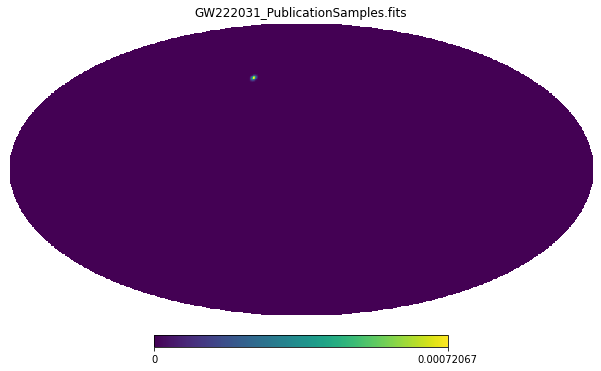

In [33]:
my_prob=my_data[0]
my_mu=my_data[1]
my_sigma=my_data[2]
my_norm=my_data[3]
npix = len(my_prob)
nside=hp.npix2nside(npix)
#my_mu[np.isinf(my_mu)]=0
print(np.sum(my_prob),(np.sum(my_norm)))
hp.mollview(my_prob, title=fname,nest=True)

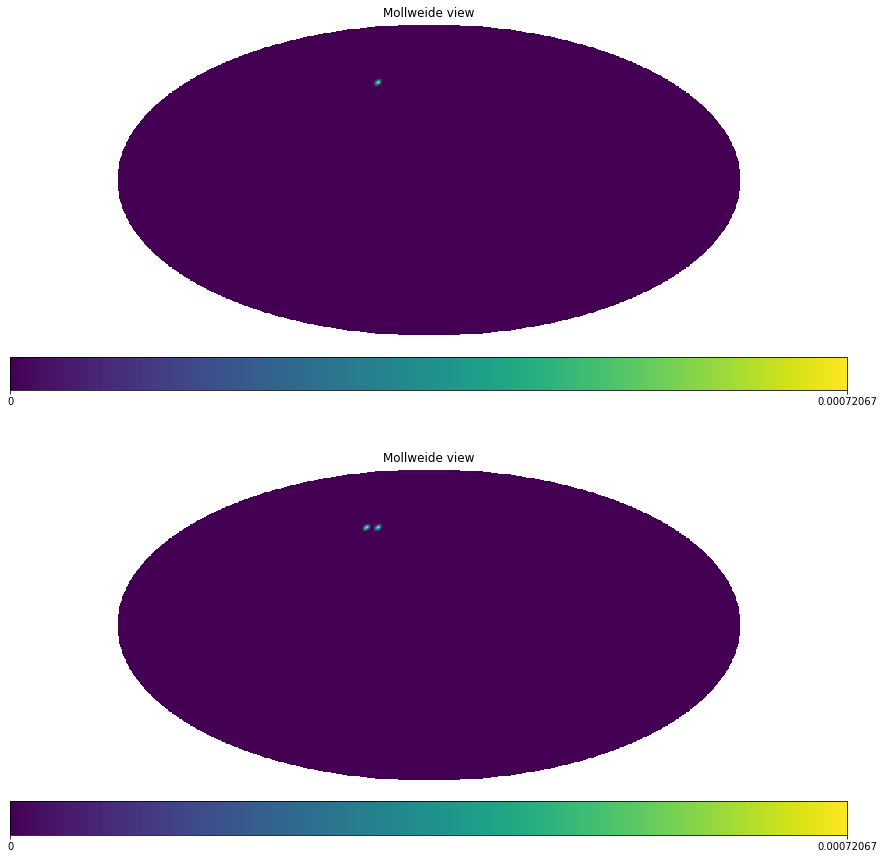

In [34]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(30,15))
gaussmap00=my_prob+gaussmap00
plt.axes(ax1)
hp.mollview(my_prob,nest=True, hold=True)

plt.axes(ax2)
hp.mollview(gaussmap00,nest=True, hold=True)

In [ ]:
credible_levels = find_greedy_credible_levels(my_prob)
Ligo_Area_99_deg=np.sum(credible_levels <= 0.99) * hp.nside2pixarea(nside, degrees=True)
Ligo_Area_90_deg=np.sum(credible_levels <= 0.9) * hp.nside2pixarea(nside, degrees=True)
print('Ligo area_deg 99% is {}\nLigo area_deg 90% is {} '.format(Ligo_Area_99_deg,Ligo_Area_90_deg))


In [ ]:
print('AngularProb')
if(np.isnan(my_prob).any()):
    print("The Array contain NaN values")
else:
    print("The Array does not contain NaN values")
if(np.isinf(my_prob).any()):
    print("The Array contain inf values")
else:
    print("The Array does not contain inf values")
    
print('Mu')
if(np.isnan(my_mu).any()):
    print("The Array contain NaN values")
else:
    print("The Array does not contain NaN values")
if(np.isinf(my_mu).any()):
    print("The Array contain inf values")
else:
    print("The Array does not contain inf values")

print('DistNorm')
if(np.isnan(my_norm).any()):
    print("The Array contain NaN values")
else:
    print("The Array does not contain NaN values")

if(np.isinf(my_norm).any()):
    print("The Array contain inf values")
else:
    print("The Array does not contain inf values")

In [ ]:
def uncorr_gauss(x,y,mux,muy,sigx,sigy):
    #correlation is 0 so is a multiplication of two gaussians
    #x is theta, y is phi
    xfactor=((x-mux)/sigx)**2
    #yfactor=((y*(1-np.sin(y))-muy*(1-np.sin(muy)))/sigy)**2
    yfactor=((y-muy)/sigy)**2
    #norm=2*np.pi*sigx*sigy
    ret=np.exp(-(1/2)*(xfactor+yfactor))#/norm
    return ret

def new_uncorr_gauss(x,y,mux,muy,sigx,sigy):
    #correlation is 0 so is a multiplication of two gaussians
    #x is theta, y is phi
    meanvec=hp.ang2vec(mux,muy)
    meanvec=np.asarray(meanvec)
    norm=np.sqrt(np.dot(meanvec,meanvec))
    meanvec=meanvec/norm
    
    var=hp.ang2vec(x,y)
    var=np.asarray(var)
    norm=np.sqrt(np.dot(var,var))
    var=var/norm
    
    diff=meanvec-var
    diff_len=np.sqrt(np.dot(diff,diff))
    #xfactor=((x-mux)/sigx)**2
    #yfactor=((y*(1-np.sin(y))-muy*(1-np.sin(muy)))/sigy)**2
    #yfactor=((y-muy)/sigy)**2
    #norm=2*np.pi*sigx*sigy
    factor=((diff_len)/sigy)**2
    ret=np.exp(-(1/2)*(factor))#/norm
    return ret

def Mises_Fisher(theta,phi,DS_theta,DS_phi,conc):
    meanvec=hp.ang2vec(DS_theta,DS_phi)
    meanvec=np.asarray(meanvec,dtype=np.float128)
    norm=np.sqrt(np.dot(meanvec,meanvec))
    meanvec=meanvec/norm
    
    var=hp.ang2vec(theta,phi)
    var=np.asarray(var,dtype=np.float128)
    norm=np.sqrt(np.dot(var,var))
    var=var/norm
    
    factor=np.dot(conc*var,meanvec)
    factor=np.float128(factor)
    #Normalization is futile, we will devide by the sum
    #fullnorm=conc/(2*np.pi*(np.exp(conc)-np.exp(-conc)))
    ret=np.float128(np.exp(factor))#/fullnorm
    #ret=factor
    return ret

radius_deg= np.sqrt(10/np.pi)
sigma90=radius_deg/np.sqrt(2)
sigma_deg=sigma90/1.5
circle_deg=6*sigma_deg
sigma_theta=np.radians(sigma_deg)
sigma_phi=np.radians(sigma_deg)

numevent=int(220000)+0
fname='GW'+str(numevent)+'_PublicationSamples.fits'
zref=1#allredshift[0]

DS_phi=0*np.pi/4
DS_theta=np.pi/2

vec = hp.ang2vec(DS_theta, DS_phi)
print(len(vec),vec)
ipix_disc = hp.query_disc(nside=nside, vec=vec, radius=np.radians(circle_deg), nest=True)
#print(DS_theta,DS_phi)
gaussmap =np.zeros(len(p_posterior),dtype=np.float128)
mod_mu=np.zeros(len(p_posterior))
mod_sigma=np.zeros(len(p_posterior))
mod_postnorm=np.zeros(len(p_posterior))
theta_arr=np.zeros(len(p_posterior))
phi_arr=np.zeros(len(p_posterior))

dlref=(1+zref)*cosmoflag.comoving_distance(zref).value
dlsig=0.01*dlref
line=[str(numevent)+'\t',str(dlref)+'\t',str(DS_theta)+'\t',str(DS_phi)+'\t',str(zref)+'\t',
     str(dlsig)+'\n']
conc=4740
for i in ipix_disc:
    theta,phi=hp.pix2ang(nside,i, nest=True)
    theta_arr[i]=theta
    phi_arr[i]=phi
    gaussmap[i]=new_uncorr_gauss(theta,phi,DS_theta,DS_phi,sigma_theta,sigma_phi)*hp.nside2pixarea(nside,degrees=False)
    #gaussmap[i]=np.float128(Mises_Fisher(theta,phi,DS_theta,DS_phi,conc))*np.float128(hp.nside2pixarea(nside,degrees=False))
    mod_mu[i]=dlref#uncorr_gauss(theta,phi)
    mod_sigma[i]=dlsig
    mod_postnorm[i]=1
#gaussmap[ipix_disc] = gaussmap[ipix_disc]
gaussmap[ipix_disc]=gaussmap[ipix_disc]/np.sum(gaussmap)

In [ ]:
credible_levels = find_greedy_credible_levels(gaussmap)
Ligo_Area_99_deg=np.sum(credible_levels <= 0.99) * hp.nside2pixarea(nside, degrees=True)
Ligo_Area_90_deg=np.sum(credible_levels <= 0.9) * hp.nside2pixarea(nside, degrees=True)
print('Ligo area_deg 99% is {}\nLigo area_deg 90% is {} '.format(Ligo_Area_99_deg,Ligo_Area_90_deg))


In [ ]:
hp.mollview(gaussmap, title=fname,nest=True)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(30,15))
#gaussmap00=gaussmap
plt.axes(ax1)
hp.mollview(gaussmap,nest=True, hold=True)

plt.axes(ax2)
hp.mollview(gaussmap00,nest=True, hold=True)

In [ ]:
print(np.sqrt(1/conc))

In [ ]:
print('AngularProb')
if(np.isnan(gaussmap).any()):
    print("The Array contain NaN values")
else:
    print("The Array does not contain NaN values")
if(np.isinf(gaussmap).any()):
    print("The Array contain inf values")
else:
    print("The Array does not contain inf values")
    
print('Mu')
if(np.isnan(mod_mu).any()):
    print("The Array contain NaN values")
else:
    print("The Array does not contain NaN values")
if(np.isinf(mod_mu).any()):
    print("The Array contain inf values")
else:
    print("The Array does not contain inf values")

print('DistNorm')
if(np.isnan(mod_postnorm).any()):
    print("The Array contain NaN values")
else:
    print("The Array does not contain NaN values")

if(np.isinf(mod_postnorm).any()):
    print("The Array contain inf values")
else:
    print("The Array does not contain inf values")

In [ ]:
allphi=phi_arr[ipix_disc]#np.linspace(0,2*np.pi,500)
allphi=np.sort(allphi)
thetafix=np.pi/4
phifix=np.pi
results=np.zeros(len(allphi))
for i in range(len(allphi)):
    results[i]=Mises_Fisher(DS_theta,allphi[i],DS_theta,DS_phi,1000)
results=results/np.sum(results)
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(15,10))
#res0=results
#n, bins, patches = plt.hist(x=numobj,grid=True, bins=Num, rwidth=0.9,color='#607c8e')
plt.plot(allphi,results,color='g')
plt.plot(allphi,res0,color='k')
plt.xlabel('dc')
plt.ylabel('# of object in a sphere')
plt.grid(axis='y', alpha=0.75)